# Automating an Ordinary Least Squares Analysis

## Project Description
    
As a part of my graduate course work, I took the class 'Regression' which takes a deep dive into the theoretical frame work of ordinary least squares, a foundation for what many people think of as a linear regression. The final project of this class was to perform a regression analysis on data found externally. I decided to focus on analyzing factors that influence the total contract amount of the active roster within the Commanders from the starting season of 2023. 

For the class, I performed the project mainly in Minitab, a commericial statistical software. However, I wanted to translate the results of the project into python, demonstrating how to perform OLS analysis through automated python code. 

Without going into the weeds too much in the analysis and just copy over my whole project, I will focus on highlights within the work, and at the end, I will describe the functionality of my different functions. For the python portion, I created functions that scales your continuous features, creates interactions between variables, performs one off OLS regression with tests for residual normality and homoskedacisty, and a forward stepwise regression. 

It is beneficial to have this sort of work automated in Python because linear regressions allow for easily explainable variable impacts. There is a less of a black box since it is easier to see that as one variable increases, the other decreases. Though a linear regression isn't for every problem, with proper attention to details, it can be adapted to many of them.

## Looking at the data
I obtained my data from spotrac.com which contains copius amounts of sports related data.
- URL: https://www.spotrac.com/nfl/washington-commanders/contracts/

For this dataset, there was not a simple download capability, so I performed the first part of my data cleaning within Excel. Here I created categorical variables for whether a player was a quarter back, on the defense or offense (or special teams), and whether or not they were drafted. Likewise, some players were not drafted, so if they were not drafted, I placed their draft round as 8, which doesn't exist but follows the draft round logic that they came "last."  I did a similar adjustment for draft pick.

In [1]:
#import regression functions
%run RegressionFunctions.ipynb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read in data
data= pd.read_excel('./Data/CommandersSalaryInfo.xlsx',sheet_name='Sheet1')
data

,Name,Age,Contract Years,Draft Round Adjusted,Drafted,Years of Experience,Contract Amount,Unnamed: 7,Offense,Defense,QB,Draft Pick
0,Daron Payne,26.0,4.0,1.0,1.0,5.0,90000000.0,NaN,0.0,1.0,0.0,13
1,Jonathan Allen,28.0,4.0,1.0,1.0,6.0,72000000.0,NaN,0.0,1.0,0.0,17
2,Terry McLaurin,28.0,3.0,3.0,1.0,4.0,68364000.0,NaN,1.0,0.0,0.0,76
3,Kendall Fuller,28.0,4.0,3.0,1.0,7.0,40000000.0,NaN,0.0,1.0,0.0,84
4,Charles Leno,32.0,3.0,7.0,1.0,9.0,37000000.0,NaN,1.0,0.0,0.0,246
...,...,...,...,...,...,...,...,...,...,...,...,...
64,Jalen Harris,24.0,1.0,8.0,0.0,0.0,750000.0,NaN,0.0,1.0,0.0,260
65,Julian Good-Jones,26.0,1.0,6.0,1.0,0.0,750000.0,NaN,1.0,0.0,0.0,216
66,De'Jon Harris,26.0,1.0,8.0,0.0,1.0,660000.0,NaN,0.0,1.0,0.0,260
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe above demonstrates that an Excel to Python pipepline is not always smooth. Especially in a business setting where data scientists are asked to look at cohorts of unrelated Excel spreadsheets, it is important to identify rows or columns that need to be dropped.

In [3]:
data.drop(['Unnamed: 7'],axis=1,inplace=True)
data = data.iloc[:67]

In [4]:
data

,Name,Age,Contract Years,Draft Round Adjusted,Drafted,Years of Experience,Contract Amount,Offense,Defense,QB,Draft Pick
0,Daron Payne,26.0,4.0,1.0,1.0,5.0,90000000.0,0.0,1.0,0.0,13
1,Jonathan Allen,28.0,4.0,1.0,1.0,6.0,72000000.0,0.0,1.0,0.0,17
2,Terry McLaurin,28.0,3.0,3.0,1.0,4.0,68364000.0,1.0,0.0,0.0,76
3,Kendall Fuller,28.0,4.0,3.0,1.0,7.0,40000000.0,0.0,1.0,0.0,84
4,Charles Leno,32.0,3.0,7.0,1.0,9.0,37000000.0,1.0,0.0,0.0,246
...,...,...,...,...,...,...,...,...,...,...,...
62,Tariq Castro-Fields,24.0,1.0,4.0,1.0,0.0,870000.0,0.0,1.0,0.0,115
63,Curtis Brooks,25.0,1.0,6.0,1.0,0.0,750000.0,0.0,1.0,0.0,221
64,Jalen Harris,24.0,1.0,8.0,0.0,0.0,750000.0,0.0,1.0,0.0,260
65,Julian Good-Jones,26.0,1.0,6.0,1.0,0.0,750000.0,1.0,0.0,0.0,216


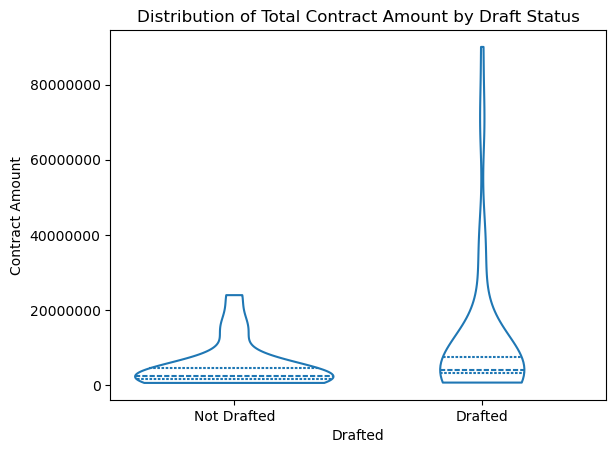

In [5]:
sns.violinplot(data, y='Contract Amount',x='Drafted',cut=0,fill=False,inner='quart')
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks([0,1],['Not Drafted','Drafted'])
plt.title('Distribution of Total Contract Amount by Draft Status')
plt.show()

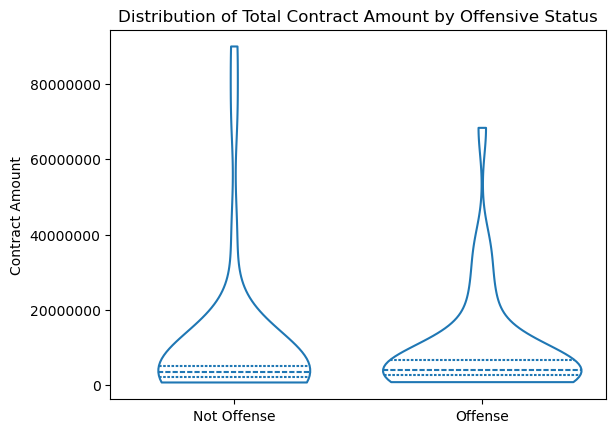

In [6]:
sns.violinplot(data, y='Contract Amount',x='Offense',cut=0,fill=False,inner='quart')
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks([0,1],['Not Offense','Offense'])
plt.title('Distribution of Total Contract Amount by Offensive Status')
plt.xlabel('')
plt.show()

The above plots are an important one. They tells us that there is a substantial difference in range within the total salaries of players that were drafted versus players that were not. Though there is a range difference between offense and non-offensive players (special team players included), that difference appears to be less than the draft status difference.

After looking into the data, it is clear that the top payed players include Jonathen Allen, Darron Payne, and Terry Mclaurin. Specifically, the Commanders are paying certain defensive linemen and wide recievers more than other notable positions such as quarter backs which usually seem like they would be the highest payed player. This makes sense given the Commanders' current quarterback is still on his rookie contract. 

Note, the lines within the plot demonstrate the 25th, 50th, and 75th percentiles. This indicates that the vast majority of players of total contract amounts of less than $20,000,000 and that there are magnitudle differences in the y's. Withouth going too fast, the magnitude differences in the contract amounts indicates to me that there may need to be a y-transformation. 

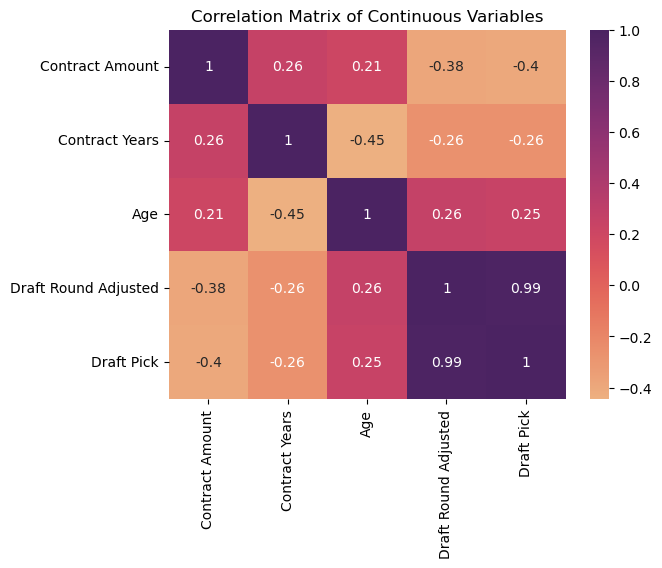

In [7]:
sns.heatmap(data[['Contract Amount','Contract Years','Age','Draft Round Adjusted','Draft Pick']].corr(),cmap='flare',annot=True)
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

A problem with OLS is that multi-collinearity within the data can negatively impact the model. Specifically, multi-collinearity, can increase the standard error of the beta's which in turn increases the range of values that a beta can take on with a specified alpha level. 

Also, looking at the original dataframe, our x's have different scales. A method I use to adjust for this is to standardize the data by subtracting the mean and dividing by the standard deviation for continuous predictors.

## Model Building

Generally, to start model building, I like to run all my variables through a single order regression and see what happens. 

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:        Contract Amount   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5.848
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           1.78e-05
Time:                        17:57:31   Log-Likelihood:                -1190.1
No. Observations:                  67   AIC:                             2398.
Df Residuals:                      58   BIC:                             2418.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.261e+06 

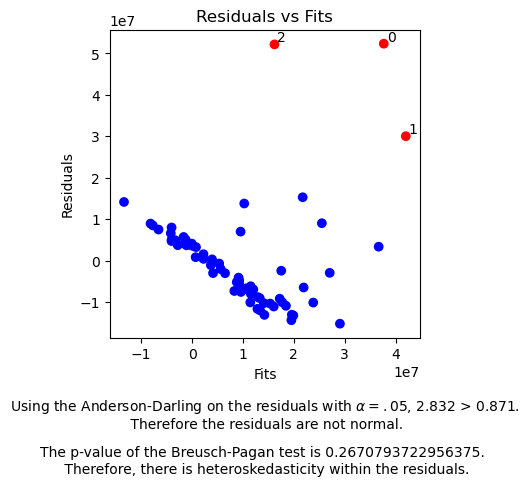

In [8]:
X = data[['Age', 'Contract Years', 'Draft Round Adjusted', 'Drafted',
       'Years of Experience', 'Draft Pick','Offense','Defense ','QB']]
y= data['Contract Amount']
OneOLSRun(X,y)

### Inital Model Breakdown + Theory

For a linear regression, the residuals (difference between the fitted value and the true value), must have a normal distribution, have a constant variance, and cannot be linearly dependent with the first two being very critical. 

I created a function OneOLSRun, that is primarily run on top of statsmodels' api for OLS. I rely on that library in order to access important values such as the R-Squared and R-Squared Adjusted which explain the amount of variation that the model accounts for and the amount of variation the model accounts for per degree of freedom (i.e. how much more each independent variable accounts for given other variables are in the model), respectively. Likewise, this library allows for diagnosics such as the Durbin-Watson statistic, conditional number, AIC/BIC, and the marginal t-test for our beta's.

So on top of displaying the model summary, I added components within my function that displays a plot of the residuals vs. the fits. This plot allows us to see if there is a constant variance. If a residual was farther than 2 standard deviations from the mean residual, I colored it red and marked it with its index for further inspect, as that is an outlying residual. 

Likewise, I output the results of the Anderson-Darling tests, a test for normality, and a Breusch-Pagan test, a test for homoskedacity, within the residuals. 

This output tells us a few things. There is super high multi-collinearity (look at the conditional number). The residuals are non-normal, and there is non-constant variance. The model only accounts for 44% of the variation within the contract amount. Likewise, a QB shouldn't be a predictor because there aren't enough QB points.

## Data Transformations and Scaling

To adjust for the heteroskedacity, I took the natural log of the contract amount. I also scaled the x's in order to get them in the same scale.

In [9]:
X = data[['Age', 'Contract Years', 'Draft Round Adjusted', 'Drafted',
       'Years of Experience', 'Draft Pick','Offense','Defense ','QB']]
y= data['Contract Amount']
Scaled_X = Scale(data,['Age', 'Contract Years', 'Draft Round Adjusted', 'Years of Experience','Draft Pick'],
                ['Drafted','Offense','Defense ', 'QB'])
Scaled_X.head(2)

,Age Standardized,Contract Years Standardized,Draft Round Adjusted Standardized,Years of Experience Standardized,Draft Pick Standardized,Drafted,Offense,Defense,QB
0,-0.04931,0.855329,-1.737434,0.826837,-1.747354,1.0,0.0,1.0,0.0
1,0.68486,0.855329,-1.737434,1.186565,-1.700749,1.0,0.0,1.0,0.0


We might also be missing information from interactions, so I placed interactions within the dataframe.

In [10]:
Int_Scaled_X = CreateInteractions(Scaled_X)
Int_Scaled_X.head(2)

,Age Standardized,Contract Years Standardized,Draft Round Adjusted Standardized,Years of Experience Standardized,Draft Pick Standardized,Drafted,Offense,Defense,QB,Age Standardized*Contract Years Standardized,...,Draft Pick Standardized*Drafted,Draft Pick Standardized*Offense,Draft Pick Standardized*Defense,Draft Pick Standardized*QB,Drafted*Offense,Drafted*Defense,Drafted*QB,Offense*Defense,Offense*QB,Defense *QB
0,-0.04931,0.855329,-1.737434,0.826837,-1.747354,1.0,0.0,1.0,0.0,-0.042176,...,-1.747354,-0.0,-1.747354,-0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.68486,0.855329,-1.737434,1.186565,-1.700749,1.0,0.0,1.0,0.0,0.585781,...,-1.700749,-0.0,-1.700749,-0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
y = np.log(data['Contract Amount'])

                            OLS Regression Results                            
Dep. Variable:        Contract Amount   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     7.635
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           1.71e-08
Time:                        17:57:32   Log-Likelihood:                -37.802
No. Observations:                  67   AIC:                             137.6
Df Residuals:                      36   BIC:                             206.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

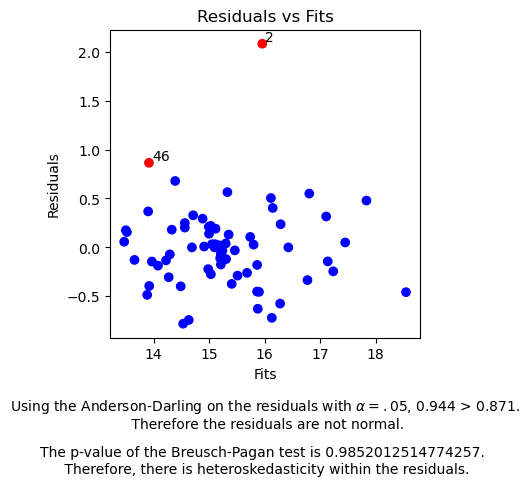

In [12]:
OneOLSRun(Int_Scaled_X,y)

This didn't perform as well either. Even though we have a higher R-Squared, that is to come with adding more variables, so we want to be selective of how we add variables. Likewise, our high multi-collinearity is likely also affecting our model. 

The heteriskedacity, though, appears to have come down a bit but is still an issue.

## Feature selection - Forward Stepwise Regression

For feature selection there is a number of methods to employ. If you are dealing with multi-collinearity, a ridge regression can be used. That can overcomplicate the model though, as it might be more difficult to explain how a ridge regression decreases multi-collinearity and that the beta's have a slightly different meaning.

Because of this, I use a forward stepwise regression (FSR). An FSR starts by building a single term model for each variable. Then, it looks at the variable with the smallest p-value and compares it to a preset alpha value. Alpha is the likelihood of rejecting the null when the null is true (i.e. saying that the beta is not 0 when it actually is). If the p-value < alpha, then that term is added to the model. Then for the second round, the FSR method adds every other variable to the model, with the initial variable included. Then looking at the marginal t-test of the added variable, it performs the same task as above. By the end, some terms may no longer be signficiant, but I can drop those terms manually.

It is important to note that there a stepwise regression allows to drop variables, a backward stepwise regression goes in the reverse direction, and measures can be made to ensure hierarchy. I decided to only include the end results of my project and manually add hierarchy when needed.

I built my own FSW function because I found that current libraries do not have much capabilities to discriminate based on notable statistical methods. Likewise, I found certain libraries that did employ statistical methods (like comparing p-values), but I did not see the results produced via Minitab, which I am taking to be the check of my work. On top of that, many of the FSW functions built relied on While-loops. I created a FSW function recursively, which I though was the most efficient way for a FSW regression. 

In [13]:
FSW(Int_Scaled_X,Int_Scaled_X.columns.to_list(),y,.05)

['Contract Years Standardized',
 'Years of Experience Standardized',
 'Draft Round Adjusted Standardized*Drafted',
 'Age Standardized*Contract Years Standardized']

                            OLS Regression Results                            
Dep. Variable:        Contract Amount   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     44.47
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           1.46e-17
Time:                        17:57:33   Log-Likelihood:                -59.352
No. Observations:                  67   AIC:                             128.7
Df Residuals:                      62   BIC:                             139.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

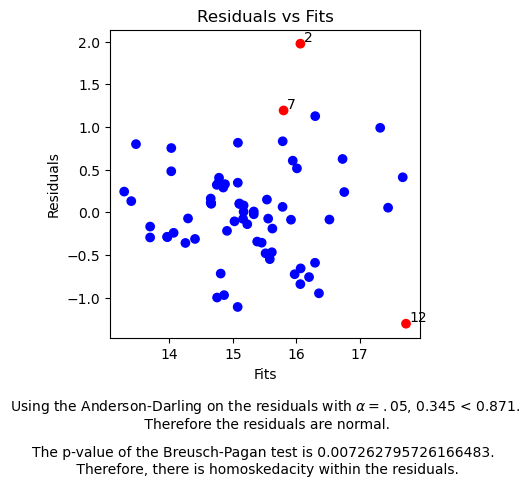

In [14]:
OneOLSRun(Int_Scaled_X[['Contract Years Standardized',
 'Years of Experience Standardized',
 'Draft Round Adjusted Standardized*Drafted',
 'Age Standardized*Contract Years Standardized']],y)


Here we finally have normal residuals, homoskedacity, and low multi-collinearity. Through Testing in Minitab, I finalized the following model.

## Final Model

                            OLS Regression Results                            
Dep. Variable:        Contract Amount   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     35.71
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           6.70e-17
Time:                        17:57:33   Log-Likelihood:                -58.856
No. Observations:                  67   AIC:                             129.7
Df Residuals:                      61   BIC:                             142.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

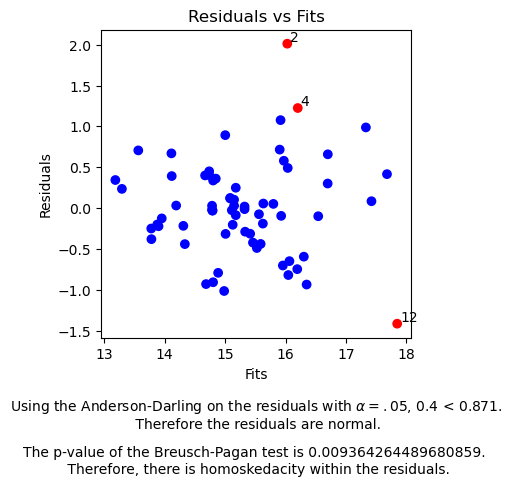

In [15]:
OneOLSRun(Int_Scaled_X[['Contract Years Standardized',
 'Years of Experience Standardized',
 'Draft Round Adjusted Standardized', 'Drafted',
 'Age Standardized*Contract Years Standardized']],y)

### Justification
It is clear that my final model is not necessarily my best model when fit to training data. I say this because my final model as a slightly higher AIC/BIC and conditional number. However, I emphasize the slight increase AIC/BIC. My goal is to have an overall simplistic model, and the interaction between draft status and draft round adds complication. Likewise, not including their first order terms goes against heirachy, but including them, because one is a categorical variable, does not work with the interaction, so I opted to rely on the first order terms. 

The increased conditional number makes sense since a drafted player will have a lower draft round pick than an undrafted player which I have designed to have the highest round. I did not apply hierachy to age because that increased the conditional number too much. 

Though not included in this display, I tested my model with three former Commander's players with different contract lengths and 2 of 3 terms fell within the 95% prediction interval. The one that did not fall in was the Kirk Cousin's contract extension which can be considered to depict the unusual nature of the contract.

### Conclusion
The biggest practical takeaway is that if a player wants a higher contract amount, they should commit to working more years. If they were not drafted, they can generally expect lower contract amounts, similar to those who were drafted later on. Otherwise, it is clear that years of experience and age generally have a positive impact on the contract amount. 

Lastly, the point of this notebook was to simply demonstrate the capability of python. Many linear regression packages do not display desired statistical outputs. Those that do, are not consolidated. Likewise, there are limited feature selection techniques that work exactly the way you want. So I demonstrated that it is feasible to get such results by combining multiple packages and techniques together.

This work leveraged sources such as GeekforGeeks and StackOverFlow as well as my education during my Master's degree. Relying on multiple sources is critical for employment functions. 